# پیش بینی 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import cv2
import numpy as np
import sys, os

def get_image (max = 0):
  # root = '/content/drive/MyDrive/RecycleIT/DATA/YOLO_imgs'
  root = '/content/drive/MyDrive/RecycleIT/DATA/data/modified_yolo_drinking_water_classification'
  for path, subdirs, files in os.walk(root):
    files = [ os.path.join(path, fi) for fi in files if  fi.endswith(".jpg") ]
    if (max==0) : max = min(len(files),max)
    for f in files[:max] :
      image_path = os.path.join(root, f)
      im = cv2.imread(image_path)
      im = cv2.resize(im, (640,640)) 
      im = im.astype(np.float32)
      im = im.T
      # yield (im , image_path)
      yield im , image_path
      # yield image_path

# اینفرنس روی GPU

In [ ]:
!pip uninstall onnxruntime
!pip install onnxruntime-gpu   # GPU build

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 111.0 MB 40 kB/s 
     |████████████████████████████████| 46 kB 3.0 MB/s 
     |████████████████████████████████| 86 kB 7.3 MB/s 


In [ ]:
import onnxruntime

sparsified_yolo5_onnx_model = '/content/drive/MyDrive/RecycleIT/MODEL/yolo5_sparssified/epoch60.onnx'
yolo5_onnx_model = '/content/drive/MyDrive/RecycleIT/MODEL/yolo5/best1.onnx'
yolo7_onnx_model_exported_by_myself = '/content/drive/MyDrive/RecycleIT/MODEL/yolov7/best_2(exported_by_myself).onnx'
yolo7_onnx_model_exported_by_FP     = '/content/drive/MyDrive/RecycleIT/MODEL/yolov7/best_2(exported_by_FP).onnx'



In [ ]:
onnxruntime.get_device()

'GPU'

In [ ]:
def get_output(onnx_model):

    options = onnxruntime.SessionOptions()
    options.enable_profiling=True

    session = onnxruntime.InferenceSession(onnx_model,
                                          sess_options=options,
                                          providers=onnxruntime.get_available_providers()
                                          #  providers=['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
                                            )
    print(onnxruntime.get_available_providers())

    input_name = session.get_inputs()[0].name
    print("input name", input_name)
    input_shape = session.get_inputs()[0].shape
    print("input shape", input_shape)
    input_type = session.get_inputs()[0].type
    print("input type", input_type)

    output_name = session.get_outputs()[0].name
    print("output name", output_name)
    output_shape = session.get_outputs()[0].shape
    print("output shape", output_shape)
    output_type = session.get_outputs()[0].type
    print("output type", output_type)

    # %time session.run([output_name], {input_name: [im]} )
    return session , input_name , output_name

## تست پروفایلر

In [ ]:
session.run([output_name], {input_name: [im]} )
session.end_profiling()

'onnxruntime_profile__2022-10-10_22-28-12.json'

In [ ]:
path = 'onnxruntime_profile__2022-10-10_21-55-47.json'
import json

with open(path, "r") as f:
    sess_time = json.load(f)
# import pprint
# pprint.pprint(sess_time)

In [ ]:
!pip install mlprodict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pandas import DataFrame
from mlprodict.onnxrt.ops_whole.session import OnnxWholeSession

df = DataFrame(OnnxWholeSession.process_profiling(sess_time))
df

,cat,pid,tid,dur,ts,ph,name,args_op_name,args_thread_scheduling_stats,args_input_type_shape,args_activation_size,args_parameter_size,args_graph_index,args_output_size,args_provider,args_output_type_shape,args_exec_plan_index
0,Session,68,68,2762684,2,X,model_loading_uri,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Session,68,68,4117562,3141308,X,session_initialization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Node,68,68,1,7479016,X,Slice_34_fence_before,Slice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Node,68,68,129,7479025,X,Slice_34_kernel_time,Slice,,"[{'float': [1, 3, 640, 640]}, {'int64': [1]}, ...",4915200,32,6,2457600,CUDAExecutionProvider,"[{'float': [1, 3, 320, 640]}]",6
4,Node,68,68,0,7479163,X,Slice_34_fence_after,Slice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,Node,68,68,0,10557220,X,Concat_746_fence_before,Concat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1128,Node,68,68,191,10557220,X,Concat_746_kernel_time,Concat,,"[{'float': [1, 19200, 9]}, {'float': [1, 4800,...",907200,0,377,907200,CUDAExecutionProvider,"[{'float': [1, 25200, 9]}]",377
1129,Node,68,68,0,10557418,X,Concat_746_fence_after,Concat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1130,Session,68,68,3078458,7478966,X,SequentialExecutor::Execute,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# ff = df[['dur', "args_op_name"]].groupby("args_op_name").sum().sort_values('dur')
# ff.sum()

dur    3075907
dtype: int64

In [ ]:
set(df['cat'])

{'Node', 'Session'}

In [ ]:
%timeit  -n1 -o session.run([output_name], {input_name: [im]} )

21.9 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 21.9 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [ ]:
%timeit -r1 -n1 -o session.run([output_name], {input_name: [im]} )

22.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 22.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [ ]:
%timeit  -r1 -o session.run([output_name], {input_name: [im]} )

13.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)


<TimeitResult : 13.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)>

In [ ]:
%timeit -o session.run([output_name], {input_name: [im]} )

13.1 ms ± 28.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 13.1 ms ± 28.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [ ]:
import time
t_start = time.perf_counter()
session.run([output_name], {input_name: [im]} )
elapsed_time = time.perf_counter() - t_start
print("inference time : {}ms".format(elapsed_time*1000) )

inference time : 24.427074999948672ms


In [ ]:
del sess

# محاسبه اینفرنس برای یولو 5 اسپارس شده

In [ ]:
from pandas import DataFrame
df = DataFrame(columns=('category', 'time', 'desc' ,'std'))

session_time =  %timeit -o session, input_name , output_name = get_output(sparsified_yolo5_onnx_model)
i = len(df)
df.loc[i] = ['create_session',session_time.average , session_time.stdev , '']

['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
input name input
input shape [1, 3, 640, 640]
input type tensor(float)
output name out_0
output shape [1, 25200, 9]
output type tensor(float)
['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
input name input
input shape [1, 3, 640, 640]
input type tensor(float)
output name out_0
output shape [1, 25200, 9]
output type tensor(float)
['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
input name input
input shape [1, 3, 640, 640]
input type tensor(float)
output name out_0
output shape [1, 25200, 9]
output type tensor(float)
['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
input name input
input shape [1, 3, 640, 640]
input type tensor(float)
output name out_0
output shape [1, 25200, 9]
output type tensor(float)
['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
input name input
input shape [1, 3, 6

In [ ]:
# image_path = '/content/drive/MyDrive/RecycleIT/DATA/data/modified_yolo_drinking_water_classification/HDPEM891.jpg'
# im = cv2.imread(image_path)
# im = cv2.resize(im, (640,640)) 
# im = im.astype(np.float32)
# im = im.T

session, input_name , output_name = get_output(sparsified_yolo5_onnx_model)
# session.run([output_name], {input_name: [im]} )

['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
input name input
input shape [1, 3, 640, 640]
input type tensor(float)
output name out_0
output shape [1, 25200, 9]
output type tensor(float)


[array([[[6.0109081e+00, 8.5193539e-01, 7.8376269e+00, ...,
          9.9972564e-01, 5.4121017e-05, 0.0000000e+00],
         [5.8292160e+00, 2.4443188e+00, 1.7098272e+01, ...,
          9.9540919e-01, 1.7228127e-03, 0.0000000e+00],
         [1.5156370e+01, 3.1618986e+00, 1.8011951e+01, ...,
          5.3744102e-01, 7.9423189e-04, 0.0000000e+00],
         ...,
         [5.5423206e+02, 6.0786755e+02, 4.0381305e+02, ...,
          8.9469564e-01, 2.1282446e-01, 2.9569864e-04],
         [5.8196423e+02, 6.0789777e+02, 3.5727084e+02, ...,
          9.0969896e-01, 2.1189207e-01, 2.4288893e-04],
         [6.1258484e+02, 6.1341833e+02, 4.0367822e+02, ...,
          9.2268538e-01, 2.1293300e-01, 2.2619963e-04]]], dtype=float32)]

In [ ]:
for img, img_path in get_image(200):
  m = %timeit -o session.run([output_name], {input_name: [img]} )
  i = len(df)
  df.loc[i] = ['inference',m.average , m.stdev , img_path]

del session
df

13.6 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.9 ms ± 26.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.2 ms ± 394 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.3 ms ± 380 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13 ms ± 42.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.8 ms ± 54.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13 ms ± 46.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.8 ms ± 73.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.9 ms ± 42.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13 ms ± 55.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.1 ms ± 64.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13 ms ± 77.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13 ms ± 65.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13 ms ± 19.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13 ms 

,category,time,desc,std
0,create_session,0.107876,0.002865,
1,inference,0.013301,0.000371,/content/drive/MyDrive/RecycleIT/DATA/data/mod...
2,inference,0.013271,0.000137,/content/drive/MyDrive/RecycleIT/DATA/data/mod...
3,inference,0.013659,0.000973,/content/drive/MyDrive/RecycleIT/DATA/data/mod...
4,inference,0.013456,0.001061,/content/drive/MyDrive/RecycleIT/DATA/data/mod...
...,...,...,...,...
201,inference,0.015733,0.003451,/content/drive/MyDrive/RecycleIT/DATA/data/mod...
202,inference,0.012956,0.000038,/content/drive/MyDrive/RecycleIT/DATA/data/mod...
203,inference,0.014643,0.001969,/content/drive/MyDrive/RecycleIT/DATA/data/mod...
204,inference,0.013610,0.000733,/content/drive/MyDrive/RecycleIT/DATA/data/mod...


In [ ]:
import pandas as pd
# df.to_excel('/content/drive/MyDrive/RecycleIT/Report/sparsified_yolo5_onnx_model_on_GPU.xlsx')
df = pd.read_excel('/content/drive/MyDrive/RecycleIT/Report/sparsified_yolo5_onnx_model_on_GPU.xlsx')

Text(0, 0.5, 'Inference time (ms)')

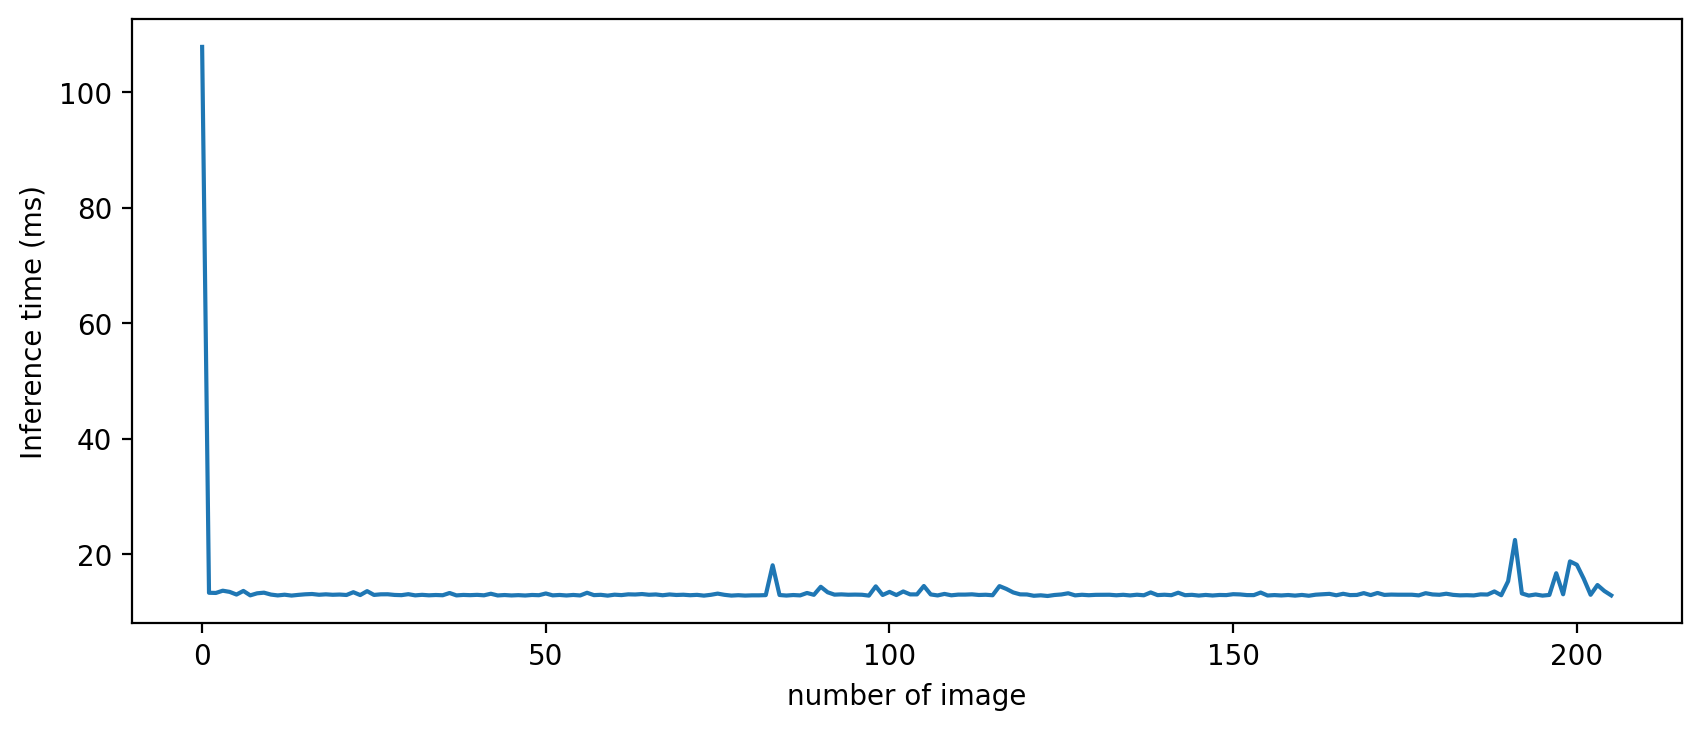

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4),dpi=200)
plt.plot(range(len(df)),df['time']*1000) #تبدیل ثانیه ب میلی ثانیه 
plt.xlabel('number of image')
plt.ylabel('Inference time (ms)')

count    205.000000
mean      13.196136
std        1.016173
min       12.743423
25%       12.882000
50%       12.945131
75%       13.039801
max       22.448751
Name: time, dtype: float64

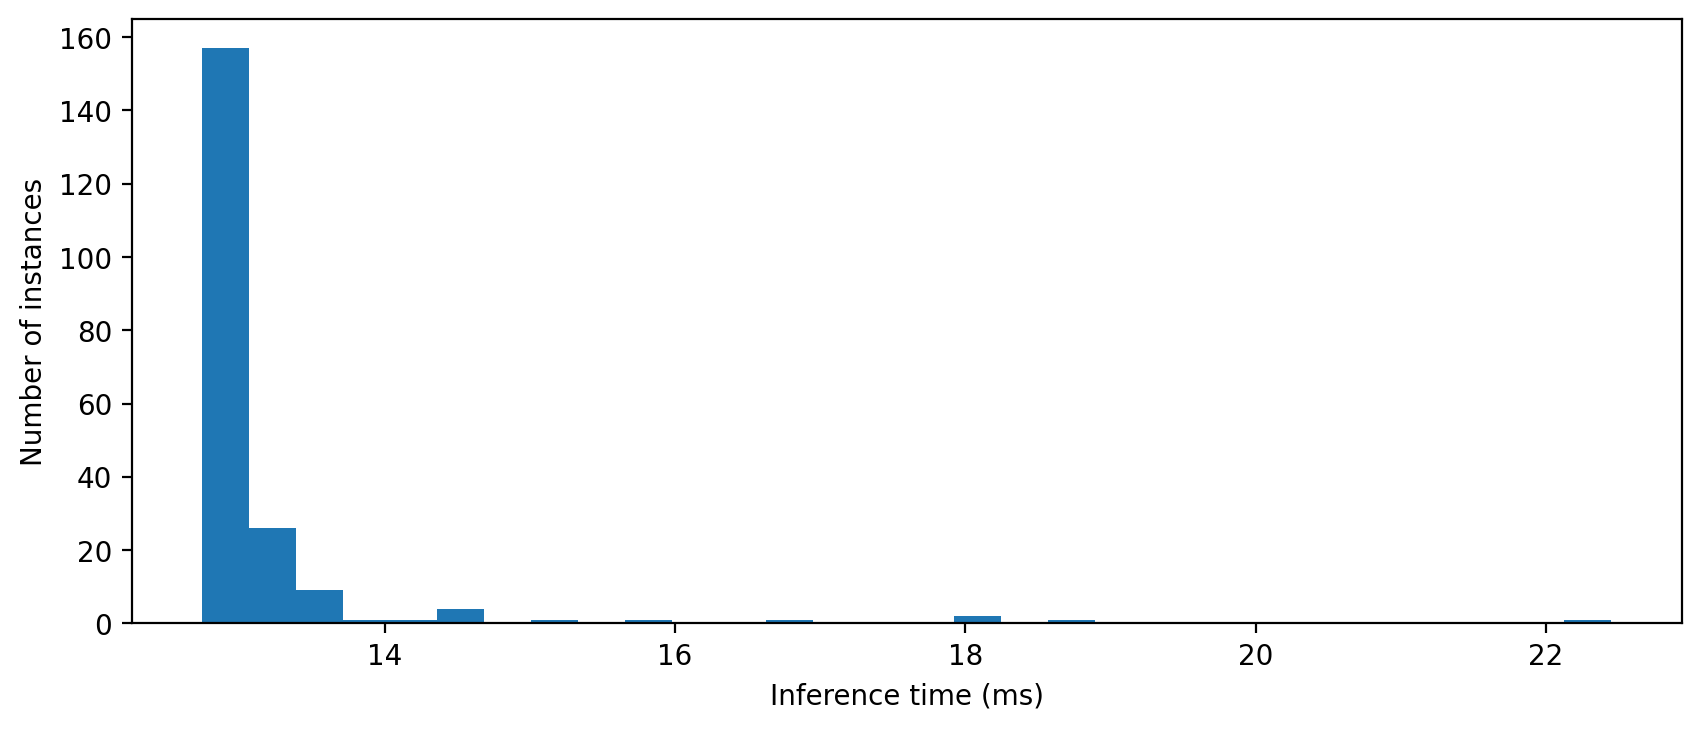

In [ ]:
plt.figure(figsize=(10,4),dpi=200)
h = df['time'][1:]* 1000
plt.hist(h,bins = 30)
# plt.plot(x = range(len(int_time)),y = int_time)
plt.xlabel('Inference time (ms)')
plt.ylabel('Number of instances')
h.describe()

# محاسبه اینفرنس برای یولو 5 معمولی

In [ ]:
df = DataFrame(columns=('category', 'time', 'desc' ,'std'))

session_time =  %timeit -o session, input_name , output_name = get_output(yolo5_onnx_model)
i = len(df)
df.loc[i] = ['create_session',session_time.average , session_time.stdev , '']

session, input_name , output_name = get_output(yolo5_onnx_model)

['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output0
output shape [1, 25200, 9]
output type tensor(float)
['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output0
output shape [1, 25200, 9]
output type tensor(float)
['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output0
output shape [1, 25200, 9]
output type tensor(float)
['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output0
output shape [1, 25200, 9]
output type tensor(float)
['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
input name images
input s

In [ ]:
df

,category,time,desc,std
0,create_session,0.09433,0.002195,


In [ ]:
for img, img_path in get_image(200):
  m = %timeit -o session.run([output_name], {input_name: [img]} )
  i = len(df)
  df.loc[i] = ['inference',m.average , m.stdev , img_path]

df.to_excel('/content/drive/MyDrive/RecycleIT/Report/yolo5_onnx_model_on_GPU.xlsx')

15.5 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
12.6 ms ± 179 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.6 ms ± 579 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.4 ms ± 3.78 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.6 ms ± 353 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.4 ms ± 162 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.3 ms ± 43.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.3 ms ± 58.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.3 ms ± 36.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.3 ms ± 36.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.4 ms ± 35.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.3 ms ± 44.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.3 ms ± 37.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12

In [ ]:
del session

Text(0, 0.5, 'Inference time (ms)')

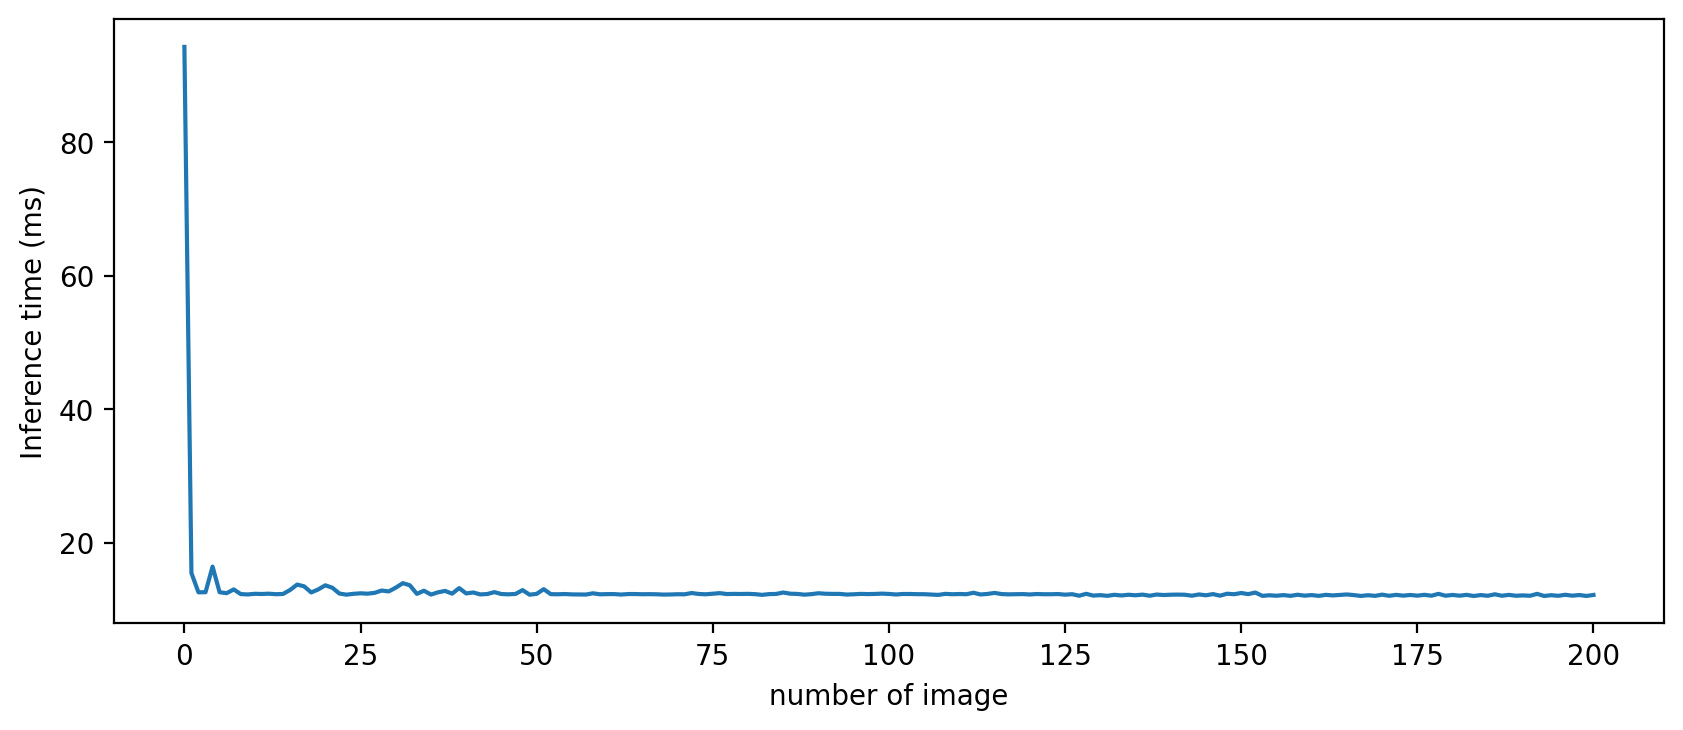

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/RecycleIT/Report/yolo5_onnx_model_on_GPU.xlsx')
plt.figure(figsize=(10,4),dpi=200)
plt.plot(range(len(df)),df['time']*1000) #تبدیل ثانیه ب میلی ثانیه 
plt.xlabel('number of image')
plt.ylabel('Inference time (ms)')

count    200.000000
mean      12.375518
std        0.474593
min       12.021722
25%       12.191564
50%       12.286303
75%       12.347229
max       16.427728
Name: time, dtype: float64

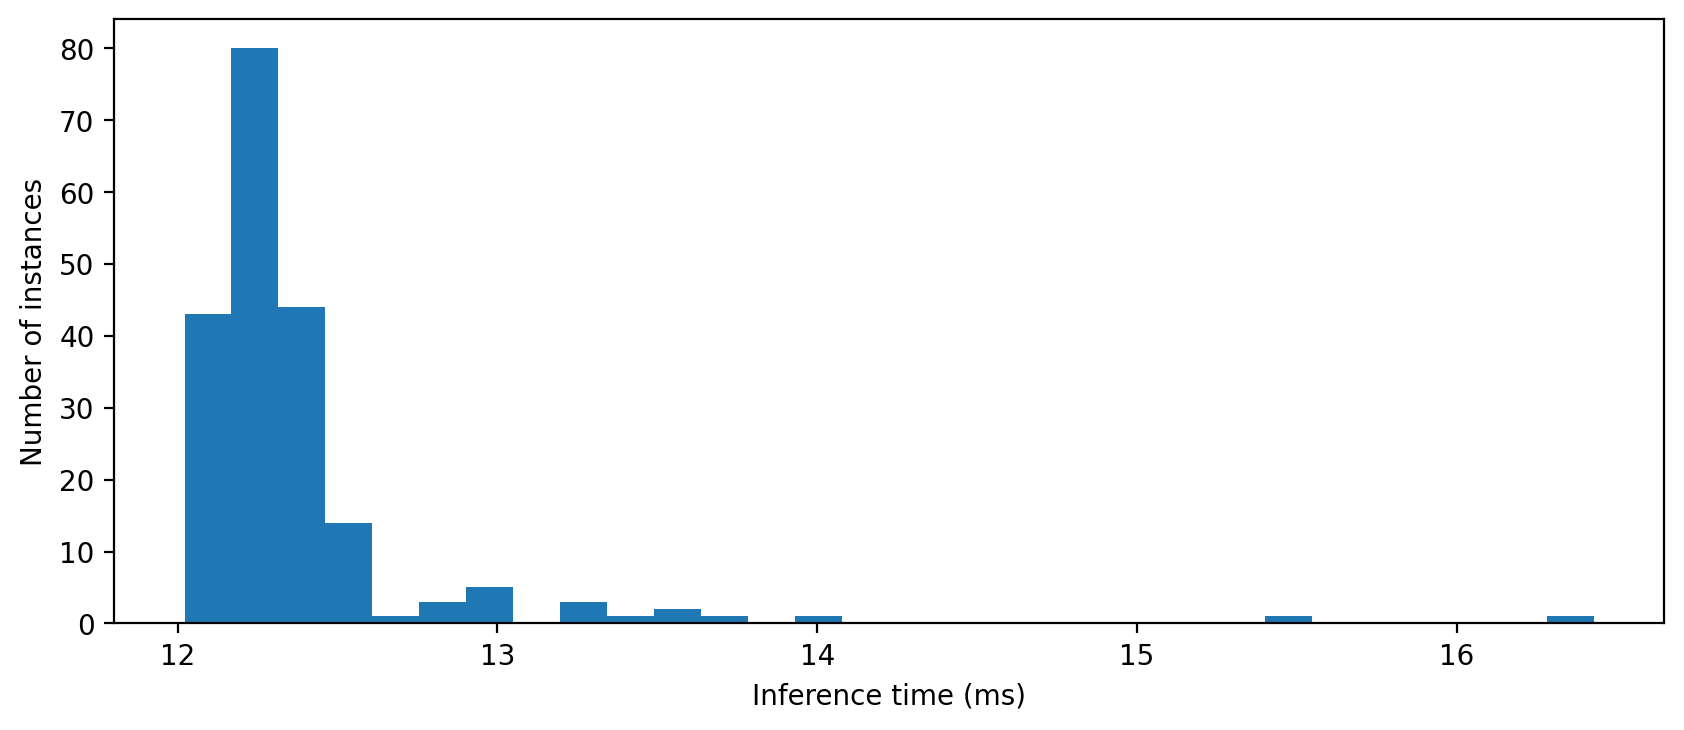

In [ ]:
plt.figure(figsize=(10,4),dpi=200)
h = df['time'][1:]* 1000 #تبدیل ثانیه ب میلی ثانیه و حذف زمان ایجاد سشن
plt.hist(h,bins = 30)
# plt.plot(x = range(len(int_time)),y = int_time)
plt.xlabel('Inference time (ms)')
plt.ylabel('Number of instances')
h.describe()

# محاسبه اینفرنس برای یولو 7 اکسپورت شده ف پ

In [ ]:
df = DataFrame(columns=('category', 'time', 'desc' ,'std'))

session_time =  %timeit -o session, input_name , output_name = get_output(yolo7_onnx_model_exported_by_FP)
i = len(df)
df.loc[i] = ['create_session',session_time.average , session_time.stdev , '']

# session, input_name , output_name = get_output(yolo5_onnx_model)

In [ ]:
session, input_name , output_name = get_output(yolo7_onnx_model_exported_by_FP)

['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output
output shape [1, 3, 80, 80, 9]
output type tensor(float)


In [ ]:
for img, img_path in get_image(200):
  m = %timeit -o session.run([output_name], {input_name: [img]} )
  i = len(df)
  df.loc[i] = ['inference',m.average , m.stdev , img_path]

df.to_excel('/content/drive/MyDrive/RecycleIT/Report/yolo7_FP_onnx_model_on_GPU.xlsx')

38.6 ms ± 646 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
39.4 ms ± 292 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
39.4 ms ± 403 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
39.5 ms ± 422 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
39.7 ms ± 259 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
39.7 ms ± 318 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
40.2 ms ± 369 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
40.5 ms ± 168 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
40.5 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
40.5 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
40.6 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
40.6 ms ± 147 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
40.7 ms ± 174 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
40.7 ms ± 201 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
40.6 ms ± 101 µs per l

Text(0, 0.5, 'Inference time (ms)')

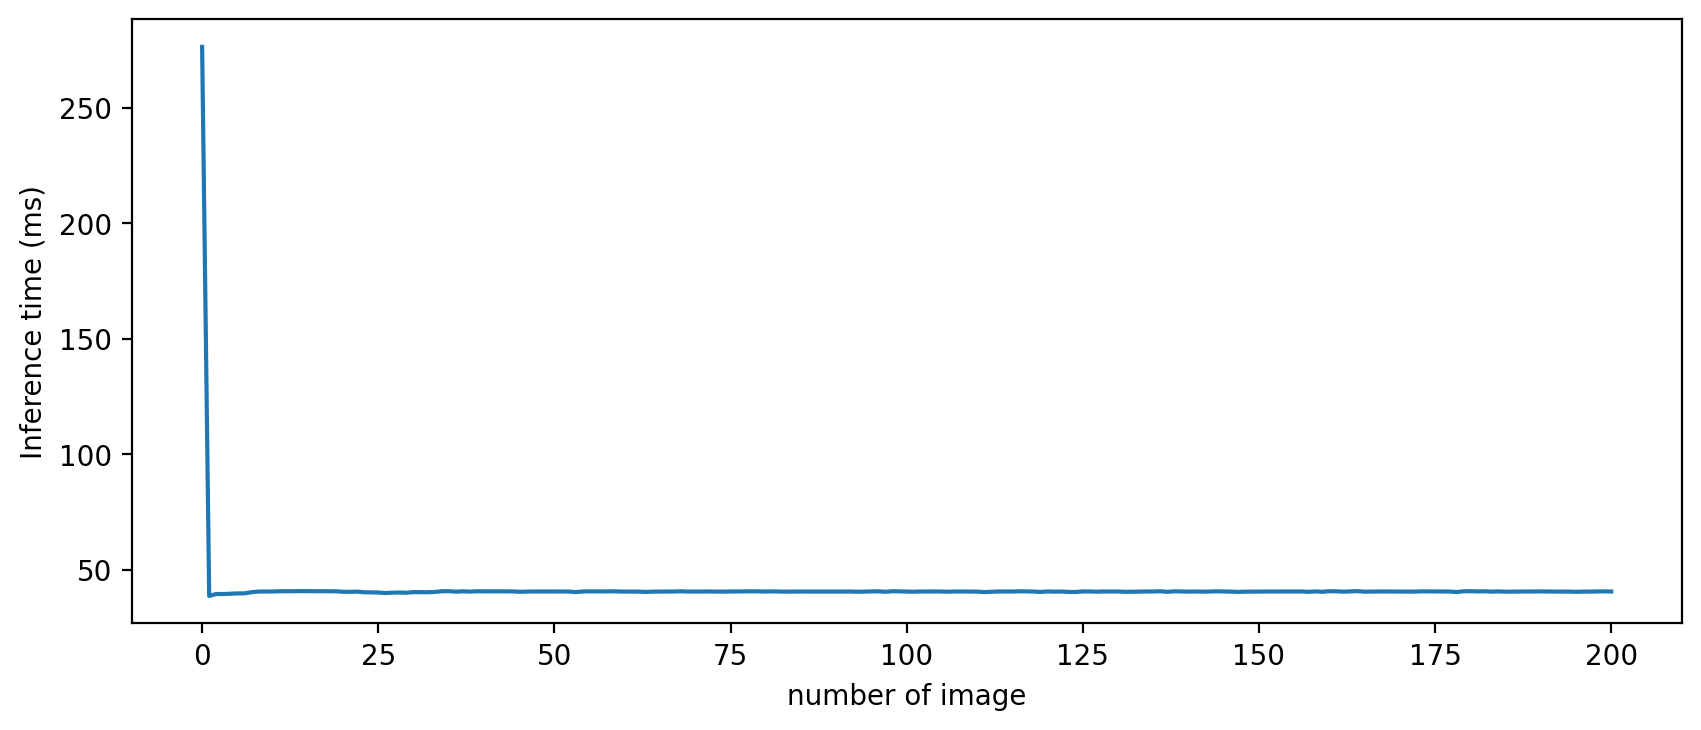

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/RecycleIT/Report/yolo7_FP_onnx_model_on_GPU.xlsx')

plt.figure(figsize=(10,4),dpi=200)
plt.plot(range(len(df)),df['time']*1000) #تبدیل ثانیه ب میلی ثانیه 
plt.xlabel('number of image')
plt.ylabel('Inference time (ms)')

count    200.000000
mean      40.435585
std        0.231226
min       38.556192
25%       40.433424
50%       40.488195
75%       40.528503
max       40.664756
Name: time, dtype: float64

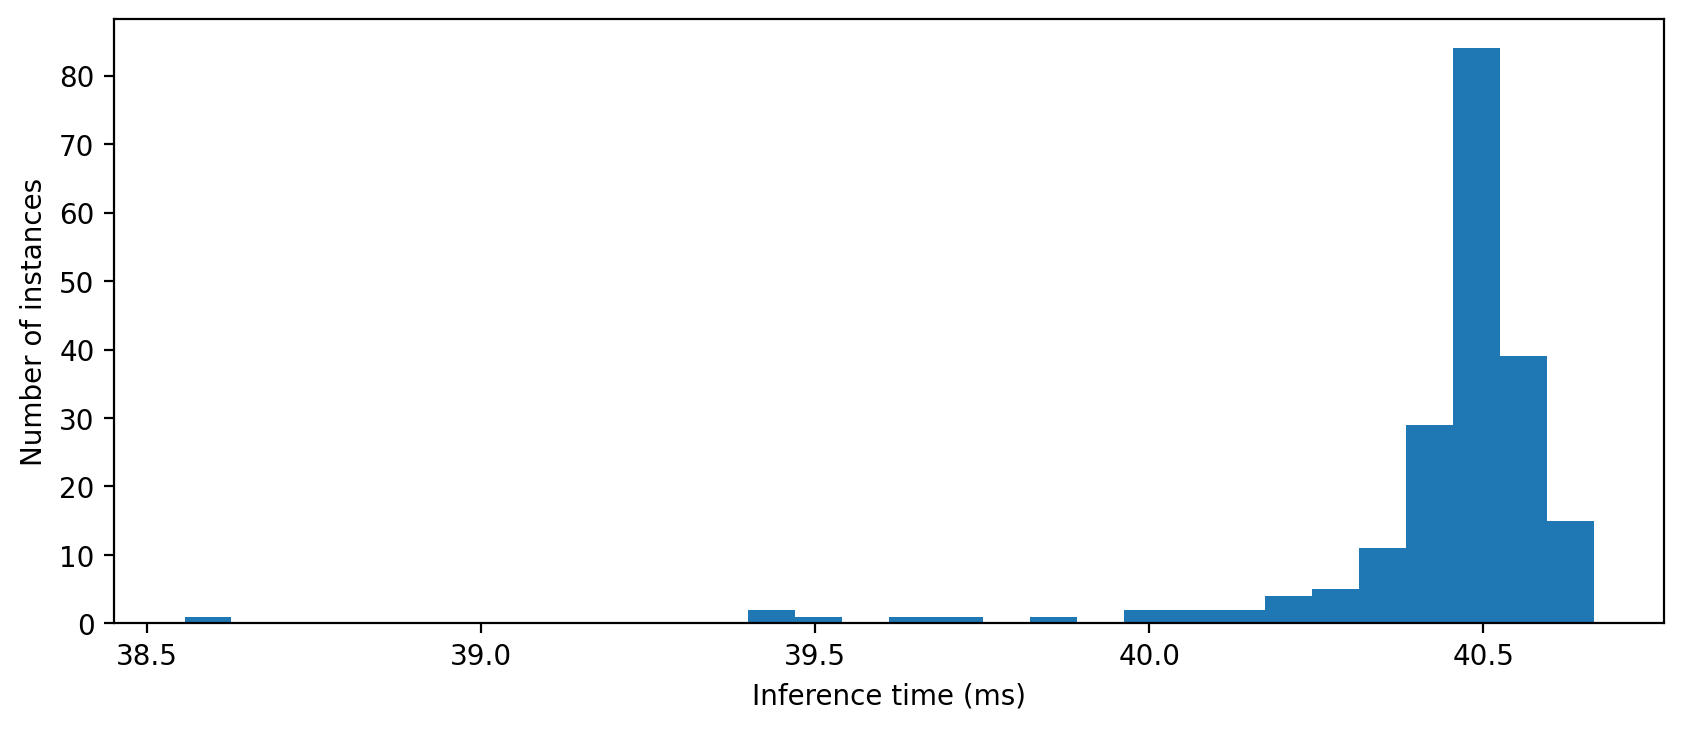

In [ ]:
plt.figure(figsize=(10,4),dpi=200)
h = df['time'][1:]* 1000 #تبدیل ثانیه ب میلی ثانیه و حذف زمان ایجاد سشن
plt.hist(h,bins = 30)
# plt.plot(x = range(len(int_time)),y = int_time)
plt.xlabel('Inference time (ms)')
plt.ylabel('Number of instances')
h.describe()

# محاسبه اینفرنس برای یولو 7 اکسپورت شده خودم

In [ ]:
from pandas import DataFrame
df = DataFrame(columns=('category', 'time', 'desc' ,'std'))

session_time =  %timeit -o session, input_name , output_name = get_output(yolo7_onnx_model_exported_by_myself)
i = len(df)
df.loc[i] = ['create_session',session_time.average , session_time.stdev , '']

# get_output(yolo7_onnx_model_exported_by_myself)
session, input_name , output_name = get_output(yolo7_onnx_model_exported_by_myself)

['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output
output shape [1, 3, 80, 80, 9]
output type tensor(float)
['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output
output shape [1, 3, 80, 80, 9]
output type tensor(float)
['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output
output shape [1, 3, 80, 80, 9]
output type tensor(float)
['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output
output shape [1, 3, 80, 80, 9]
output type tensor(float)
['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
input name im

In [ ]:
df

,category,time,desc,std
0,create_session,0.418124,0.057978,


In [ ]:
for img, img_path in get_image(200):
  m = %timeit -o session.run([output_name], {input_name: [img]} )
  i = len(df)
  df.loc[i] = ['inference',m.average , m.stdev , img_path]

df.to_excel('/content/drive/MyDrive/RecycleIT/Report/yolo7_myself_onnx_model_on_GPU.xlsx')

38.2 ms ± 465 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
38.5 ms ± 281 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
38.4 ms ± 198 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
38.4 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
38.4 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
38.3 ms ± 176 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
38.6 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
38.6 ms ± 295 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
38.8 ms ± 149 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
39 ms ± 260 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
38.9 ms ± 204 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
39 ms ± 206 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
39.2 ms ± 249 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
39.2 ms ± 236 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
39.1 ms ± 321 µs per loop 

Text(0, 0.5, 'Inference time (ms)')

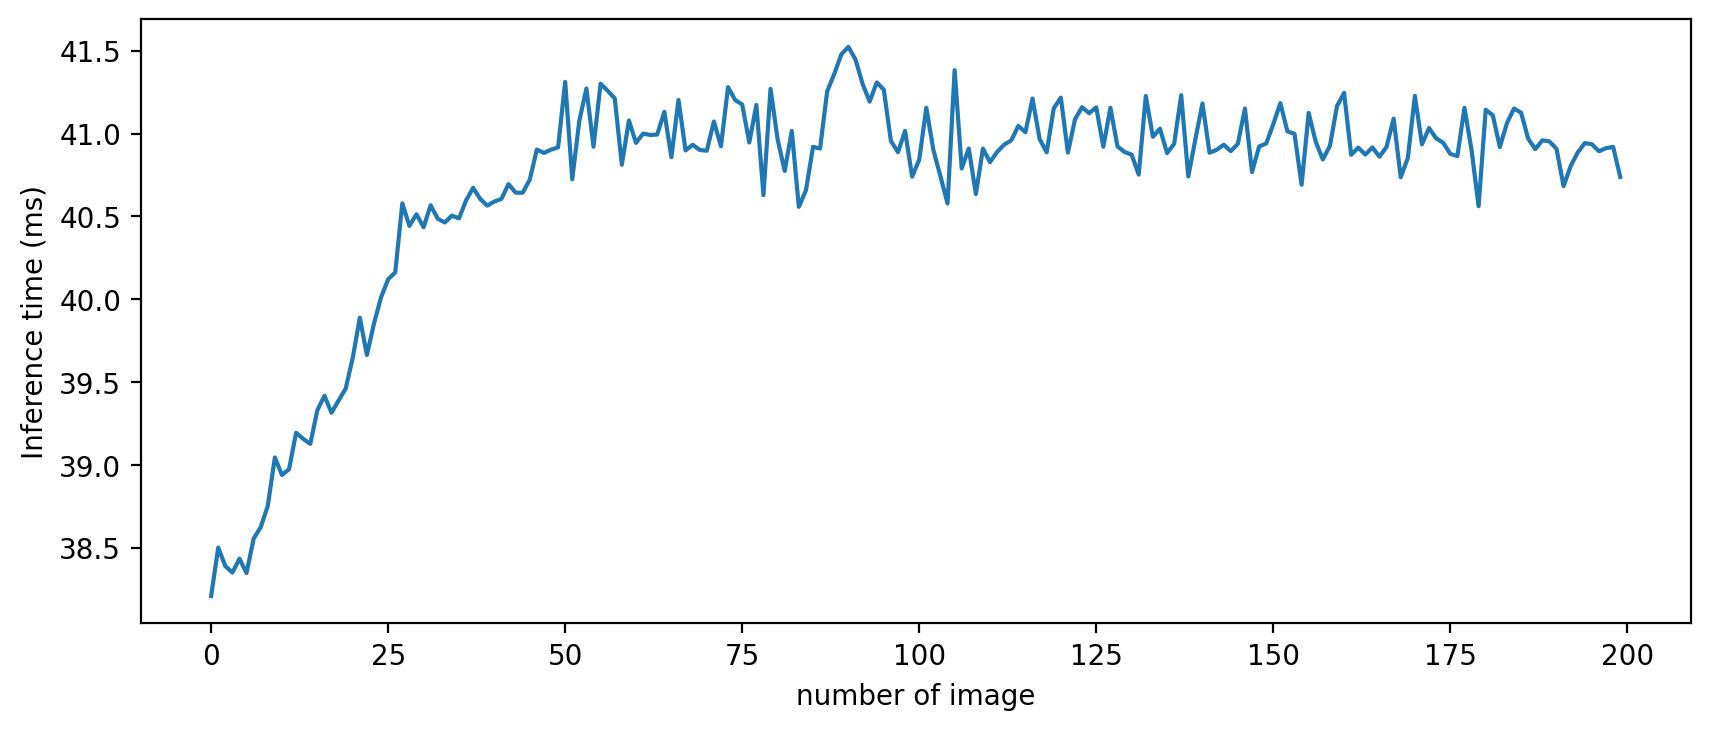

In [ ]:
import matplotlib.pyplot as plt
df = pd.read_excel('/content/drive/MyDrive/RecycleIT/Report/yolo7_myself_onnx_model_on_GPU.xlsx')
plt.figure(figsize=(10,4),dpi=200)
plt.plot(range(len(df)-1),(df['time'][1:])*1000) #تبدیل ثانیه ب میلی ثانیه 
plt.xlabel('number of image')
plt.ylabel('Inference time (ms)')

count    200.000000
mean      40.701017
std        0.684289
min       38.209510
25%       40.680589
50%       40.909880
75%       41.057988
max       41.522924
Name: time, dtype: float64

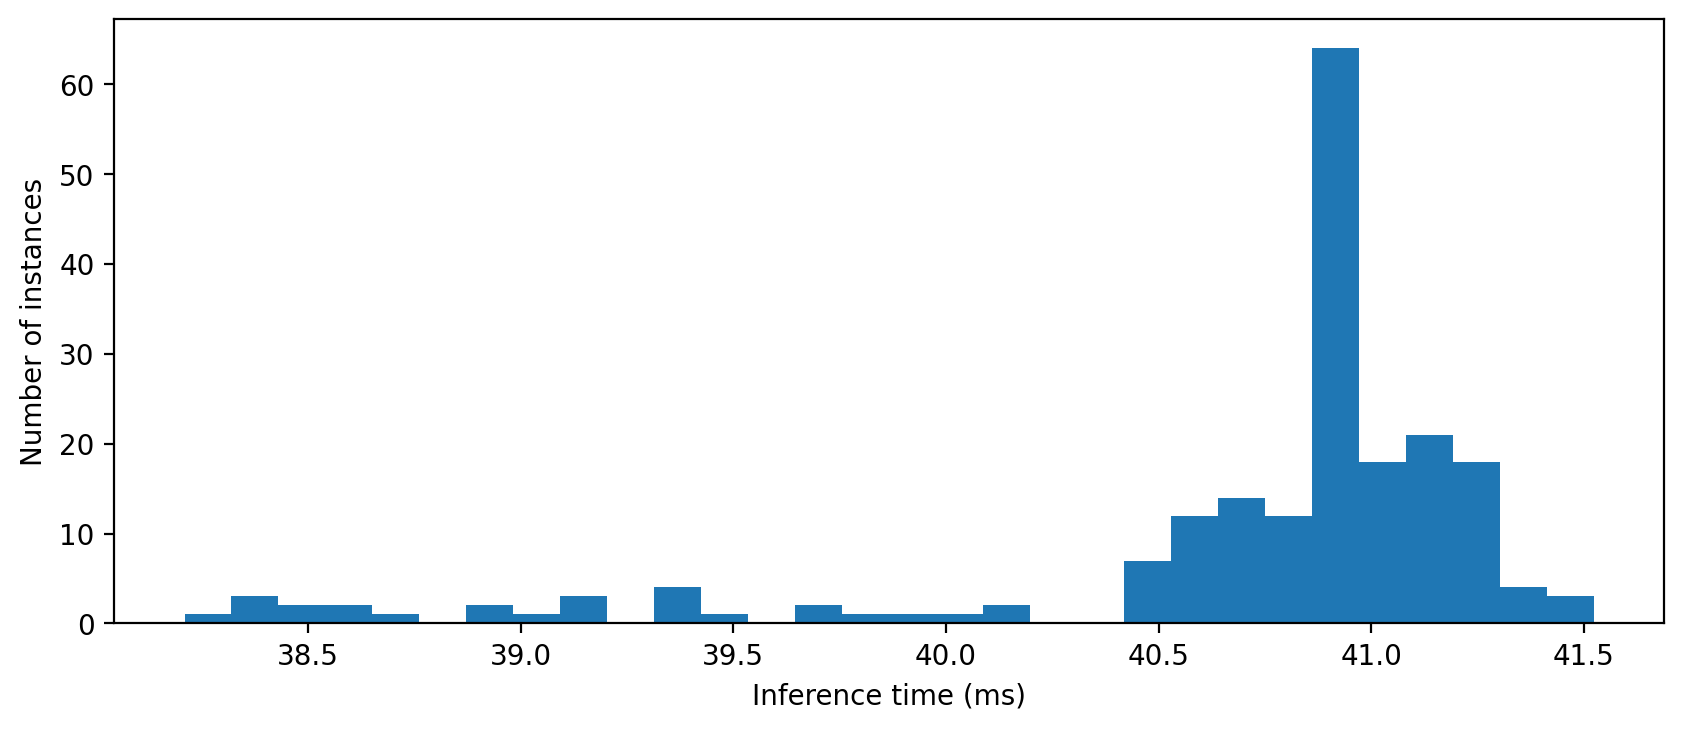

In [ ]:
plt.figure(figsize=(10,4),dpi=200)
h = df['time'][1:]* 1000 #تبدیل ثانیه ب میلی ثانیه و حذف زمان ایجاد سشن
plt.hist(h,bins = 30)
# plt.plot(x = range(len(int_time)),y = int_time)
plt.xlabel('Inference time (ms)')
plt.ylabel('Number of instances')
h.describe()